In [1]:
import os

os.chdir("../..")
os.getcwd()

'/home/mario/PhD/spatial_lda'

In [2]:
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import subprocess
import pymc3 as pm
import seaborn as sns

from spatial_mix.utils import *
from spatial_mix.protos.py.univariate_mixture_state_pb2 import UnivariateState, UnivariateMixtureState, HdpState

current_palette = sns.color_palette()

In [3]:
with open("notebooks/amsterdam_airbnb/amsterdam.pkl", "rb") as fp:
    datas = pickle.load(fp)

In [4]:
datas.keys()

dict_keys(['y', 'G', 'neigh_names', 'cov'])

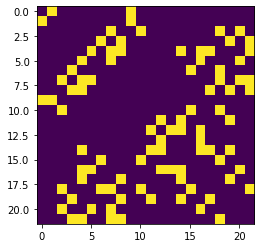

In [5]:
plt.imshow(datas["G"])

In [8]:
covariates = ["host_is_superhost", "accommodates", "bathrooms", "bedrooms", "number_of_reviews", "review_scores_rating", "instant_bookable"]

In [9]:
covariates_by_group = []
for i, cov in enumerate(datas["cov"]):      
    curr = cov[covariates]
    if(curr.isna().sum().sum()):
        print("Nans in group {0}".format(i))
        
    curr.loc[:, "host_is_superhost"] = (curr["host_is_superhost"]=="t").astype(int).values
    curr.loc[:, "instant_bookable"] = (curr["instant_bookable"]=="t").astype(int).values
    covariates_by_group.append(curr.values)

In [17]:
for i in range(len(covariates_by_group)):
    if len(datas["y"][i]) != covariates_by_group[i].shape[0]:
        print("error in ", i)
        print("datas: ", len(datas["y"][i]), " covariates", covariates_by_group[i].shape[0])

error in  2
datas:  1005  covariates 1006
error in  4
datas:  1478  covariates 1483
error in  5
datas:  1884  covariates 1900
error in  6
datas:  129  covariates 130
error in  7
datas:  2990  covariates 2994
error in  8
datas:  2134  covariates 2136
error in  13
datas:  322  covariates 323
error in  16
datas:  525  covariates 527
error in  20
datas:  1288  covariates 1290
error in  21
datas:  1169  covariates 1175


In [13]:
len(datas["y"][0])

91

In [15]:
covariates_by_group[0].shape[0]

91

In [ ]:
chains = runSpatialMixtureSampler(
    10000, 10000, 5, datas["G"], 
    "spatial_mix/resources/sampler_params.asciipb",
    datas["y"], covariates_by_group)